# Figure: within-subject encoding

In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py
import cortex
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy import stats

from util import plot
from util.path import Path
from util.stats import ttest_1samp
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS, BLU, ORG

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
modelname = "model-gpt2-2b_layer-24"

features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

encmodel = "encoding_trialmot6_wx"

# cache = 'nomot'  # no motion confounds at all
cache = encmodel.split("_")[-1]

FG_MASK = get_brainmask()

modelname, encmodel, cache

('model-gpt2-2b_layer-24', 'encoding_trialmot6_wx', 'wx')

In [4]:
cachedir = f'cache/figure-enc/{modelname}/{cache}'
!mkdir -p $cachedir

In [5]:
prod_cmap = 'YlOrRd_r'
comp_cmap = prod_cmap

# Load results

In [6]:
respath = Path(
    root=encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results = defaultdict(list)
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", respath.fpath)
        continue
    with h5py.File(respath, "r") as f:
        for key in ["cv_scores_prod", "cv_scores_comp"]:  # , "cv_scores"]:
            results[key].append(f[key][...])
        # results['inprod'].append(f['cv_prodmask'][...])

 19%|█▉        | 11/58 [00:00<00:01, 31.95it/s]

skip encoding_trialmot6_wx/sub-108/model-gpt2-2b_layer-24/sub-108.hdf5
skip encoding_trialmot6_wx/sub-111/model-gpt2-2b_layer-24/sub-111.hdf5
skip encoding_trialmot6_wx/sub-116/model-gpt2-2b_layer-24/sub-116.hdf5
skip encoding_trialmot6_wx/sub-117/model-gpt2-2b_layer-24/sub-117.hdf5


 47%|████▋     | 27/58 [00:01<00:01, 22.66it/s]

skip encoding_trialmot6_wx/sub-143/model-gpt2-2b_layer-24/sub-143.hdf5


 64%|██████▍   | 37/58 [00:01<00:00, 22.31it/s]

skip encoding_trialmot6_wx/sub-008/model-gpt2-2b_layer-24/sub-008.hdf5
skip encoding_trialmot6_wx/sub-011/model-gpt2-2b_layer-24/sub-011.hdf5
skip encoding_trialmot6_wx/sub-016/model-gpt2-2b_layer-24/sub-016.hdf5
skip encoding_trialmot6_wx/sub-017/model-gpt2-2b_layer-24/sub-017.hdf5


 95%|█████████▍| 55/58 [00:02<00:00, 22.17it/s]

skip encoding_trialmot6_wx/sub-043/model-gpt2-2b_layer-24/sub-043.hdf5


100%|██████████| 58/58 [00:02<00:00, 22.45it/s]


In [7]:
# scores without splitting into prod/comp time points
all_scores_prod = np.stack(results["cv_scores_prod"])  # sub, run, feature, voxel
all_scores_comp = np.stack(results["cv_scores_comp"])  # sub, run, feature, voxel
all_scores_lang = (all_scores_prod[:, :, -2] + all_scores_comp[:, :, -1]).mean(1)
all_scores_prod.shape

(48, 5, 5, 81924)

In [8]:
avg_scores_prod = all_scores_prod.mean((0, 1))
avg_scores_comp = all_scores_comp.mean((0, 1))
avg_scores_lang = avg_scores_prod[-2] + avg_scores_comp[-1]
avg_scores_prod.shape

(5, 81924)

## Statistical test

In [9]:
sigmask = ttest_1samp(all_scores_lang)
sigmask.sum()

13755

In [14]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    cmap = plt.get_cmap(cmap)
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [15]:
prod_cmap = truncate_colormap('rainbow_r', minval=0.5, maxval=1, n=256)
comp_cmap = truncate_colormap('rainbow', minval=0.5, maxval=1, n=256)

prod_cmap.set_bad(prod_cmap.get_over())
comp_cmap.set_bad(comp_cmap.get_over())

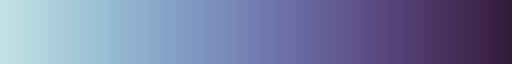

In [56]:
prod_cmap = sns.cubehelix_palette(start=0.5, rot=-0.4, as_cmap=True)
prod_cmap

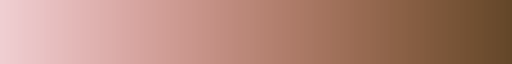

In [57]:
comp_cmap = sns.cubehelix_palette(start=1.4, rot=-0.2, as_cmap=True, dark=0.3)
comp_cmap

In [7]:
prod_cmap = 'Blues'
comp_cmap = 'Oranges'

# Plot LLM encoding performance

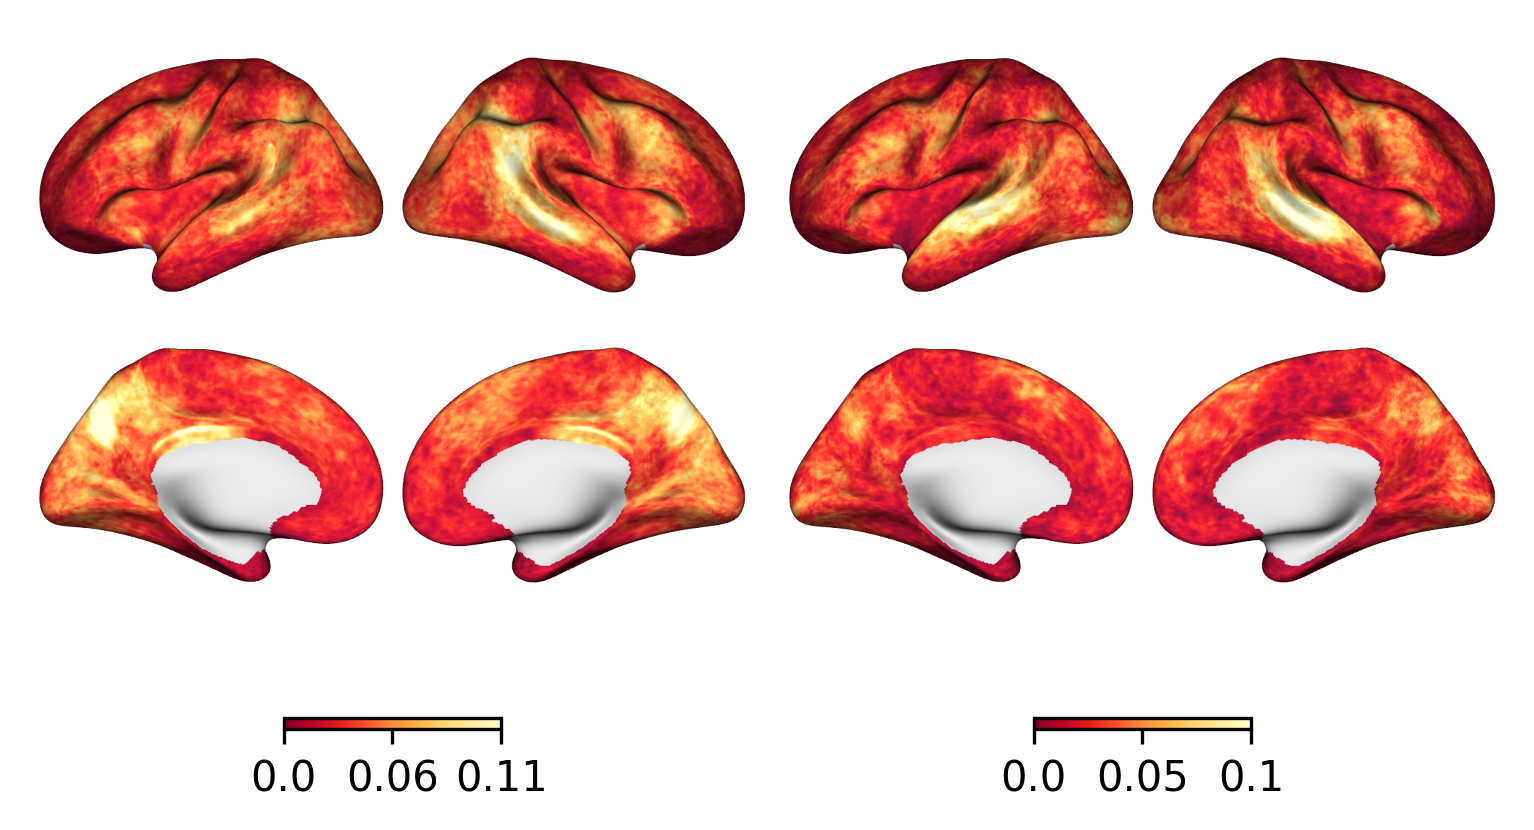

In [11]:
values1 = avg_scores_prod[-2].copy()
values2 = avg_scores_comp[-1].copy()

fig, axes = plt.subplots(1, 2, figsize=(5, 5), layout='constrained', dpi=300)
plot.surface_plot(values1, fig=fig, ax=axes[0], cmap=prod_cmap, vmin=0)
plot.surface_plot(values2, fig=fig, ax=axes[1], cmap=comp_cmap, vmin=0)
# fig.suptitle(modelname[6:] + f" ({len(features)} spaces) ({cache})")
fig.show()

## flatmap

In [10]:
values1[~sigmask] = np.nan
values2[~sigmask] = np.nan
values1 = plot.upsample_fsaverage(values1)
values2 = plot.upsample_fsaverage(values2)
vmin1, vmin2 = None, None
volume = cortex.Vertex2D(
    values1, values2, "fsaverage", cmap="PU_BuOr_covar", vmin=vmin1, vmin2=vmin2
)

/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: divide by zero encountered in buffer
  return lib.buffer(


Setting _INKSCAPE_GC=disable as a workaround for broken libgc
Unable to init server: Could not connect: Connection refused
(ld-linux-x86-64.so.2:4084911): glibmm-WARNING **: 15:36:04.103: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.


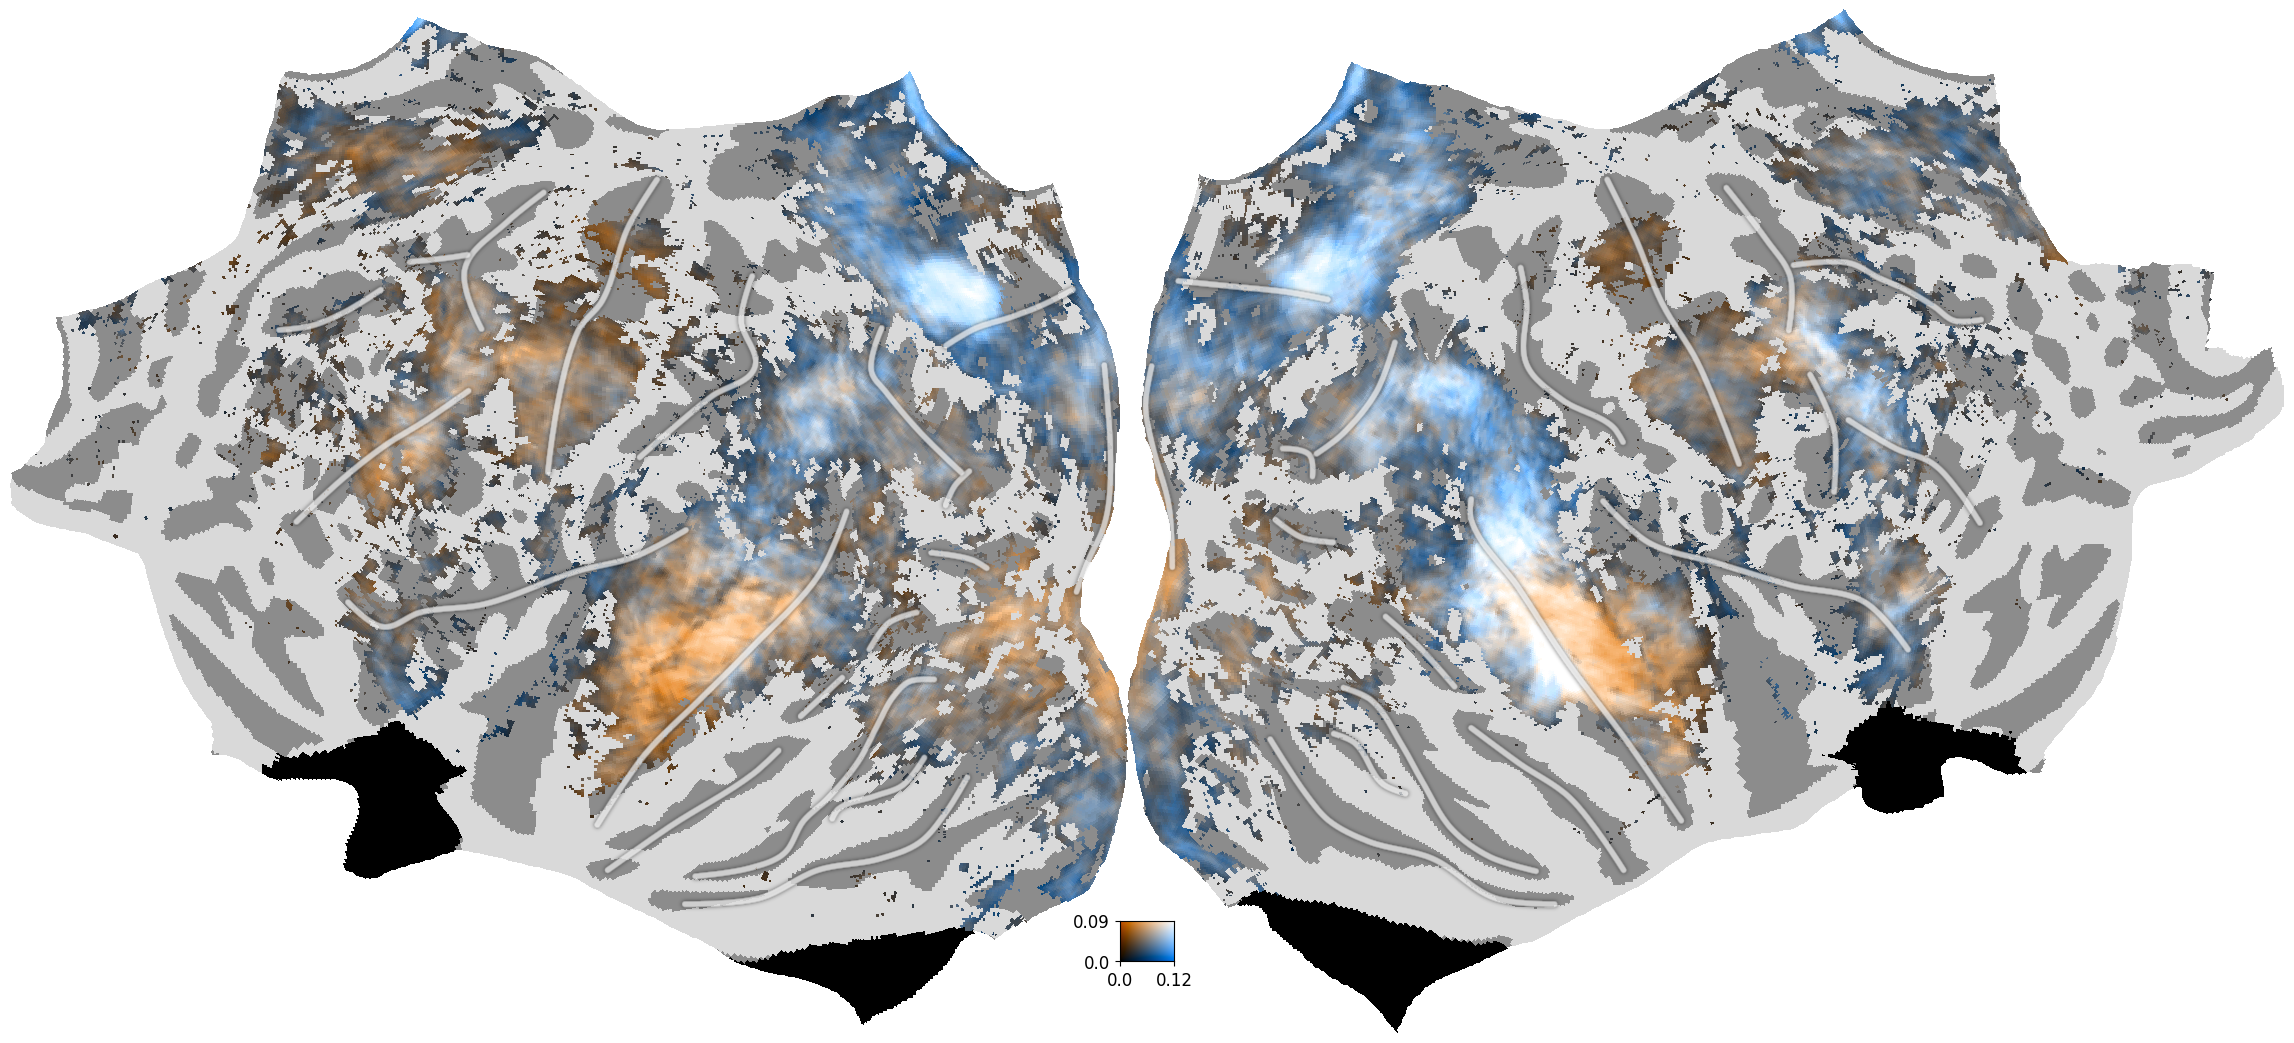

In [11]:
fig = cortex.quickflat.make_figure(
    volume,
    with_sulci=True,
    with_rois=False,
    with_labels=False,
    with_curvature=True,
    curvature_brightness=0.7,
    curvature_contrast=0.3,
)

# scatter prod and comp

In [15]:
fgmask = get_brainmask()
values1 = avg_scores_prod[-2][fgmask]
values2 = avg_scores_comp[-1][fgmask]

In [16]:
stats.pearsonr(values1, values2), 1/ len(values1)

(PearsonRResult(statistic=0.6725833076711707, pvalue=0.0),
 1.3342762218634503e-05)

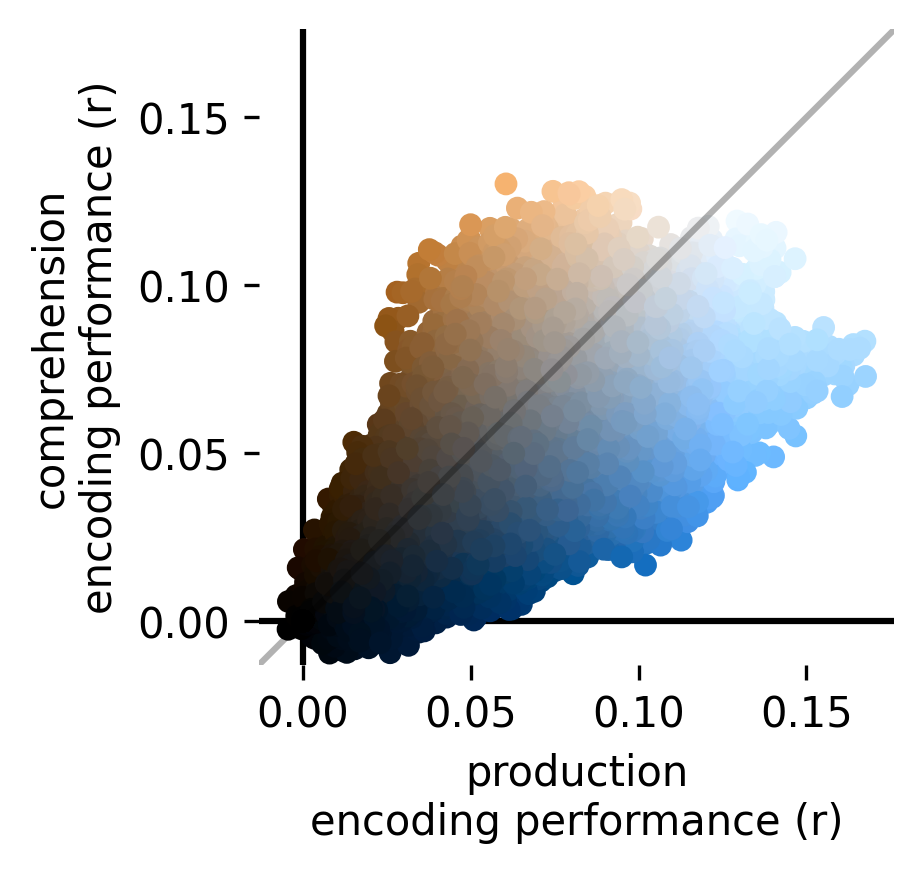

In [67]:
vox_colors = plot.Colormap2D(vmin=0, vmin2=0, vmax=0.13, vmax2=0.13)(
    np.vstack((values1, values2)).T
)
vox_colors = np.stack((vox_colors)).T / 255

fig = plt.figure(figsize=(2.75, 2.75), dpi=300)
ax = fig.add_subplot()

ax.axvline(0, c="k", zorder=1, alpha=1)
ax.axhline(0, c="k", zorder=1, alpha=1)
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, color="k")
# im = ax.hexbin(values1, values2, bins="log", cmap='grey', gridsize=100)
# im = ax.scatter(values1, values2, color='black', edgecolors="white", linewidths=0.5, s=15, marker='o')
im = ax.scatter(
    values1, values2, c=vox_colors, s=20
)  # , edgecolors="white", linewidths=0.5, s=20, marker='o')
ax.set_aspect("equal", "box")

# roi_labels = {
#     "aTemp": "RH_Lang_aSTS",
#     "pTemp": "RH_Lang_pSTS",
#     "EAC": "RH_AUD_EAC",
# }
# for label, roi in roi_labels.items():
#     roimask = catlas.roimask([roi])
#     x_roi = np.mean(values1[roimask[fgmask]])
#     y_roi = np.mean(values2[roimask[fgmask]])
#     ax.text(
#         x_roi,
#         y_roi,
#         label,
#         ha="center",
#         va="center",
#         size=8,
#         bbox=dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(0.8, 0.8, 0.8)),
#     )

lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], lim)
ax.set_ylim(ax.get_xlim()[0], lim)

ax.set_xlabel("production\nencoding performance (r)")
ax.set_ylabel("comprehension\nencoding performance (r)")

# cbar = fig.colorbar(im, shrink=0.86)
# cbar.set_label("density")

sns.despine(fig, left=True, bottom=True)

fig.show()

# encoding performance per feature space

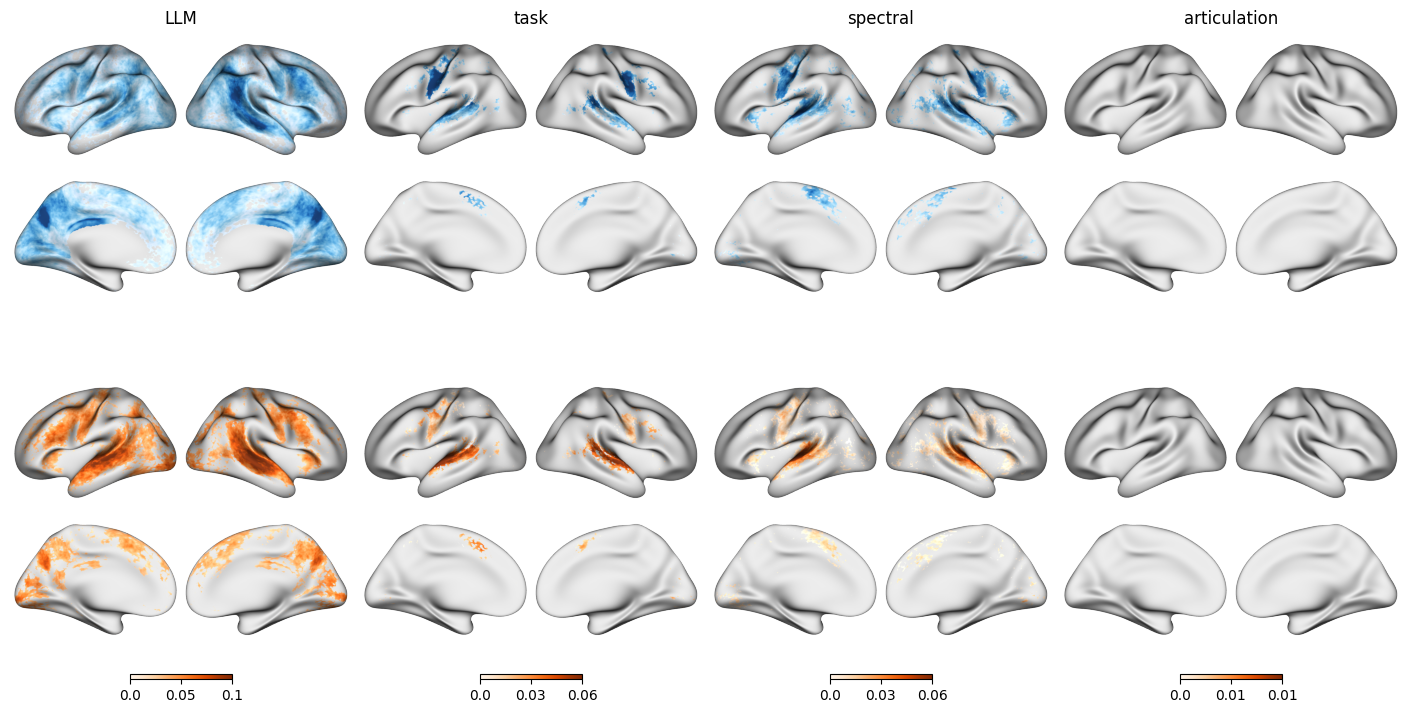

In [65]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7), layout="constrained")
# joint
# plot.surface_plot(avg_scores_prod.sum(0), fig=fig, ax=axes[0,0], vmin=0.0, cmap="hot")
# plot.surface_plot(avg_scores_comp.sum(0), fig=fig, ax=axes[1,0], vmin=0.0, cmap="hot")

ttest_args = dict(method='fdr_by', alpha=0.01)
plot_args = dict(vmin=0)

brainmask  = ~ ttest_1samp(np.mean(all_scores_prod[:, :, 0, :] + all_scores_comp[:, :, 0, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_prod[0], threshold=brainmask, fig=fig, ax=axes[0, 1], cmap=prod_cmap, cbar=False, **plot_args)
plot.surface_plot(avg_scores_comp[0], threshold=brainmask, fig=fig, ax=axes[1, 1], cmap=comp_cmap, cbar=True, **plot_args)

brainmask  = ~ ttest_1samp(np.mean(all_scores_prod[:, :, 1, :] + all_scores_comp[:, :, 1, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_prod[1], threshold=brainmask, fig=fig, ax=axes[0, 2], cmap=prod_cmap, cbar=False, **plot_args)
plot.surface_plot(avg_scores_comp[1], threshold=brainmask, fig=fig, ax=axes[1, 2], cmap=comp_cmap, cbar=True, **plot_args)

brainmask  = ~ ttest_1samp(np.mean(all_scores_prod[:, :, 2, :] + all_scores_comp[:, :, 2, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_prod[2], threshold=brainmask, fig=fig, ax=axes[0, 3], cmap=prod_cmap, cbar=False, **plot_args)
plot.surface_plot(avg_scores_comp[2], threshold=brainmask, fig=fig, ax=axes[1, 3], cmap=comp_cmap, cbar=True, **plot_args)

# brainmask  = ~ ttest_sig(np.mean(all_scores_prod[:, :, 3, :] + all_scores_comp[:, :, 4, :], axis=1), **ttest_args)
brainmask  = ~ ttest_1samp(np.mean(all_scores_prod[:, :, 3, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_prod[3], threshold=brainmask, fig=fig, ax=axes[0, 0], cmap=prod_cmap, cbar=False, **plot_args)
brainmask  = ~ ttest_1samp(np.mean(all_scores_comp[:, :, 4, :], axis=1), **ttest_args)
plot.surface_plot(avg_scores_comp[4], threshold=brainmask, fig=fig, ax=axes[1, 0], cmap=comp_cmap, cbar=True, **plot_args)

axes[0, 0].set_title("LLM")
axes[0, 1].set_title("task")
axes[0, 2].set_title("spectral")
axes[0, 3].set_title("articulation")

axes[0, 0].set_ylabel('production')
axes[1, 0].set_ylabel('comprehension')

fig.show()

# preference map

In [67]:
from matplotlib.colors import ListedColormap

In [50]:
features

['task', 'spectral', 'articulation', 'prod-LLM', 'comp-LLM']

In [60]:
prod_prefs = np.argmax(avg_scores_prod[[0,1,2,3], :], 0) + 1
comp_prefs = np.argmax(avg_scores_comp[[0,1,2,4], :], 0) + 1

In [65]:
np.unique(prod_prefs, return_counts=True)

(array([1, 2, 3, 4]), array([10129,  2224,    32, 69539]))

In [66]:
np.unique(comp_prefs, return_counts=True)

(array([1, 2, 3, 4]), array([ 7879,  1461,   386, 72198]))

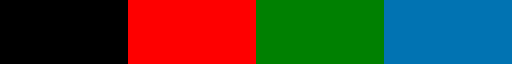

In [88]:
cmap = ListedColormap(['black', 'red', 'green', BLU])
cmap

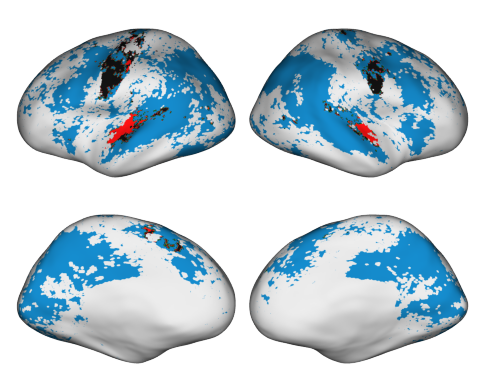

In [89]:
plot.surface_plot(prod_prefs, cmap=cmap, vmin=1, vmax=5, threshold=~sigmask, cbar=False,
    surf_lh_fn= "mats/suma-fsaverage6/lh.inflated.gii",
    surf_rh_fn= "mats/suma-fsaverage6/rh.inflated.gii",
                  );

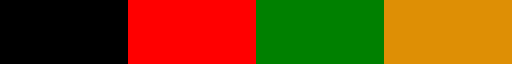

In [90]:
cmap = ListedColormap(['black', 'red', 'green', ORG])
cmap

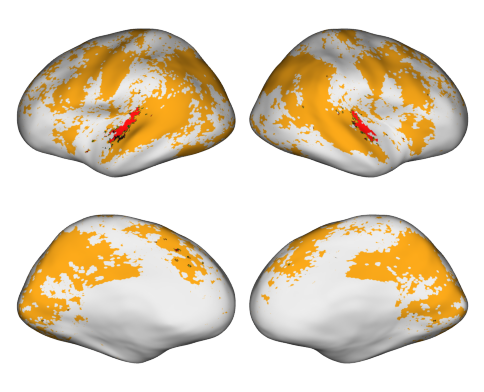

In [91]:
plot.surface_plot(comp_prefs, cmap=cmap, vmin=1, vmax=5, threshold=~sigmask, cbar=False,
    surf_lh_fn= "mats/suma-fsaverage6/lh.inflated.gii",
    surf_rh_fn= "mats/suma-fsaverage6/rh.inflated.gii",
                  );

# joint performance

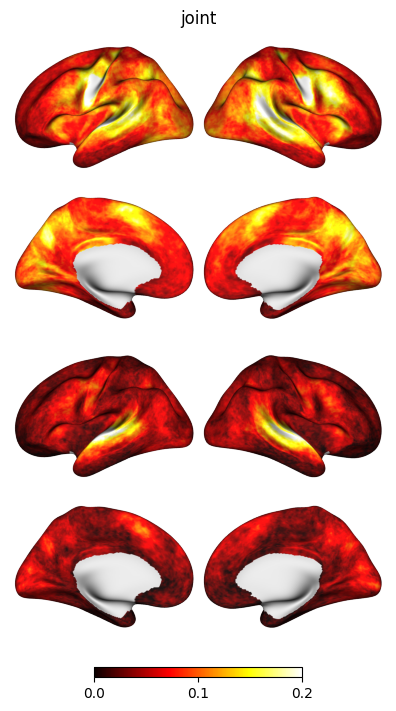

In [45]:
brainmask = ~sigmask
brainmask = None

fig, axes = plt.subplots(2, 1, figsize=(7, 7), layout="constrained")

# axes[0].set_title('joint')
# plot.surface_plot(avg_scores_prod.sum(0), threshold=brainmask, fig=fig, ax=axes[0], vmin=0.0, cmap="hot")
# plot.surface_plot(avg_scores_comp.sum(0), threshold=brainmask, fig=fig, ax=axes[1], vmin=0.0, cmap="hot")

axes[0].set_title("joint")
plot.surface_plot(avg_scores_prod.sum(0), threshold=brainmask, fig=fig, ax=axes[0], cmap='hot', vmin=0.0, vmax=0.2, cbar=False)
plot.surface_plot(avg_scores_comp.sum(0), threshold=brainmask, fig=fig, ax=axes[1], cmap='hot', vmin=0.0, vmax=0.2)

fig.show()

## ROI-level

In [6]:
catlas = Atlas.load("custom_glasser_group")

In [32]:
scoresP = catlas.vox_to_parc(avg_scores_prod)
scoresC = catlas.vox_to_parc(avg_scores_comp)
scoresP.shape

(5, 22)

In [33]:
df = pd.DataFrame(index=catlas.labels)
df["task"] = scoresP[0] + scoresC[0]
df["spectral"] = scoresP[1] + scoresC[1]
df["articulation"] = scoresP[2] + scoresC[2]
df["prod-LLM"] = scoresP[3]
df["comp-LLM"] = scoresC[4]
df.head()

task  spectral  articulation  prod-LLM  comp-LLM
LH_LangS   0.046297  0.039592      0.010687  0.046049  0.036329
LH_MOT     0.057328  0.042709      0.007912  0.044114  0.040662
LH_AUD     0.063003  0.092585      0.011046  0.053444  0.044065
LH_LangT   0.060860  0.045369      0.014923  0.054143  0.069478
LH_LangPT  0.043824  0.034496      0.012716  0.059960  0.043909

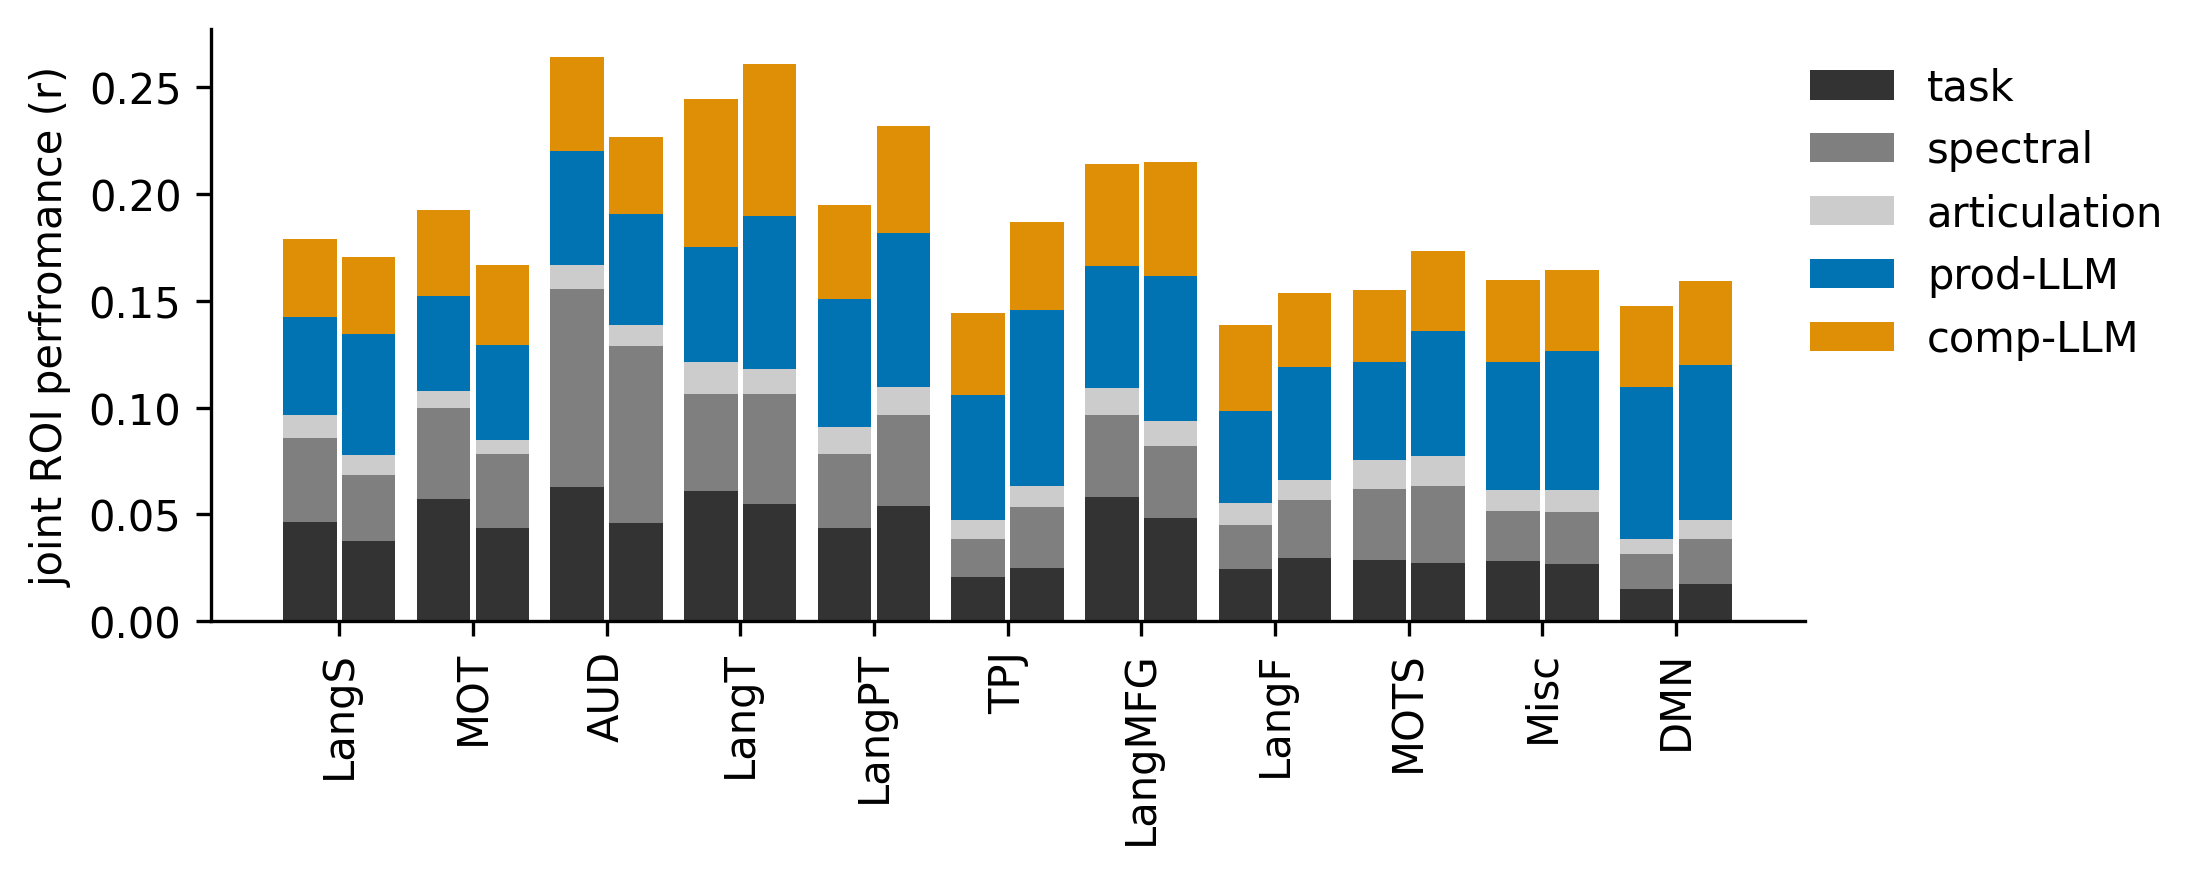

In [71]:
width = 0.4

fig, ax = plt.subplots(figsize=(7.25, 2.8), layout='constrained', dpi=300)

subdf1 = df.iloc[:len(df)//2]
subdf = df.iloc[len(df)//2:]
xlabels = subdf.index
bottom = np.zeros(len(xlabels))
colors = ["#333333", "#7f7f7f", "#CCCCCC", BLU, ORG]

xaxis = np.arange(len(xlabels))

for feature, color in zip(features, colors):
    values = subdf1[feature]
    p = ax.bar(xaxis - .02, values, -width, bottom=bottom, color=color, align='edge')
    bottom += values

bottom = np.zeros(len(xlabels))

for feature, color in zip(features, colors):
    values = subdf[feature]
    p = ax.bar(xaxis + .02, values, width, label=feature, bottom=bottom, color=color, align='edge')
    bottom += values

ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels([label.split('_')[1] for label in xlabels], rotation=90)

ax.set_ylabel('joint ROI perfromance (r)')
ax.legend(loc="upper left", frameon=False, bbox_to_anchor=(0.98, 1))
sns.despine(fig)

fig.show()

## plot brains

In [22]:
from surfplot import Plot

In [34]:
catlas.labels

['LH_LangS',
 'LH_MOT',
 'LH_AUD',
 'LH_LangT',
 'LH_LangPT',
 'LH_TPJ',
 'LH_LangMFG',
 'LH_LangF',
 'LH_MOTS',
 'LH_Misc',
 'LH_DMN',
 'RH_LangS',
 'RH_MOT',
 'RH_AUD',
 'RH_LangT',
 'RH_LangPT',
 'RH_TPJ',
 'RH_LangMFG',
 'RH_LangF',
 'RH_MOTS',
 'RH_Misc',
 'RH_DMN']

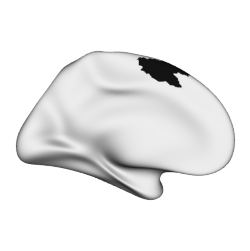

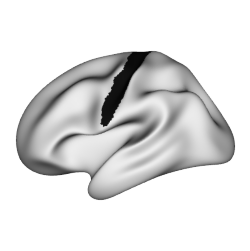

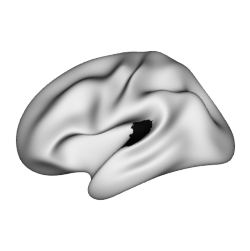

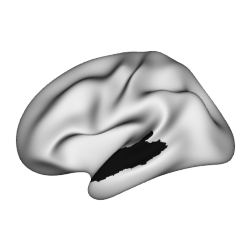

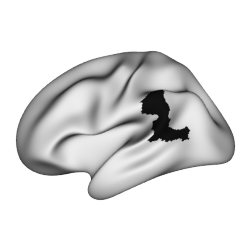

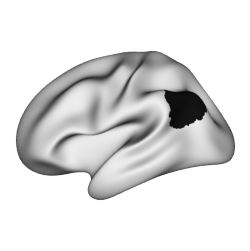

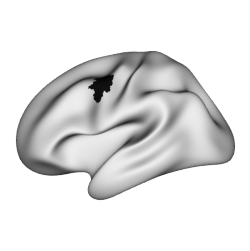

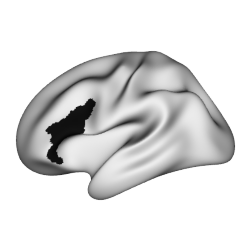

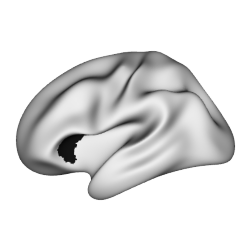

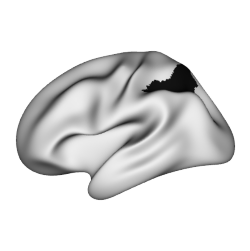

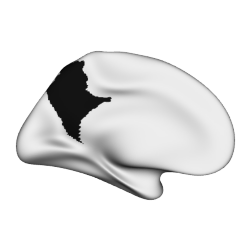

In [40]:
for i, label in enumerate(catlas.labels[:len(catlas)//2], 1):
    roimask = catlas.roimask([i]).astype(int)

    view = 'lateral'
    if 'LangS' in label or 'DMN' in label:
        view = 'medial'

    p = Plot("mats/suma-fsaverage6/lh.inf_120.gii", views=view, brightness=0.7, size=(200, 200), zoom=1.2)
    p.add_layer(roimask[:roimask.size//2], cmap='Grays', color_range=(0, 1), cbar=False)
    fig = p.build()
    fig.show()

# compare with head motion

In [33]:
from util.path import Path
from scipy.stats import pearsonr

In [107]:
stat = np.mean

cachepath = Path(
    root="data/derivatives/cleaned",
    sub="000",
    datatype="func",
    task="Conv",
    space="fsaverage6",
    desc=cache,
    suffix="confounds",
    ext=".npy",
)

prod_fds = []
comp_fds = []
prod_scs = []
comp_scs = []

for subA in tqdm(SUBS_STRANGERS):
    cachepath.update(sub=f'{subA:03d}')
    fd = np.load(cachepath).reshape(5, 240)

    encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        prod_mask = f["cv_prodmask"][...]
        prod_scores = f["cv_scores_prod"][:, -2]
        comp_scores = f["cv_scores_comp"][:, -1]
    
    for i in range(5):
        prod_fd = fd[i, prod_mask[i]]
        comp_fd = fd[i, ~prod_mask[i]]
        prod_sc = prod_scores[i]
        comp_sc = comp_scores[i]

        prod_fds.append(stat(prod_fd, axis=-1))
        comp_fds.append(stat(comp_fd, axis=-1))
        prod_scs.append(stat(prod_sc, axis=-1))
        comp_scs.append(stat(comp_sc, axis=-1))


100%|██████████| 58/58 [00:02<00:00, 19.69it/s]


In [110]:
r_prod = pearsonr(prod_fds, prod_scs)
r_comp = pearsonr(comp_fds, comp_scs)

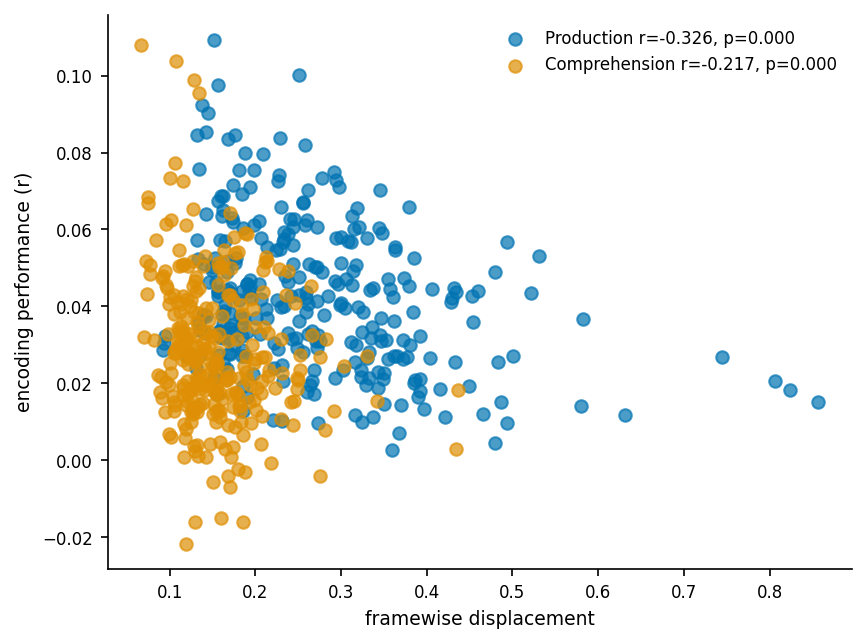

In [113]:
fig, ax = plt.subplots()
ax.scatter(prod_fds, prod_scs, alpha=0.7, c=BLU, label=f'Production r={r_prod.statistic:.3f}, p={r_prod.pvalue:.3f}')
ax.scatter(comp_fds, comp_scs, alpha=0.7, c=ORG, label=f'Comprehension r={r_comp.statistic:.3f}, p={r_comp.pvalue:.3f}')
ax.set_xlabel('framewise displacement')
ax.set_ylabel('encoding performance (r)')
ax.legend()
fig.show()

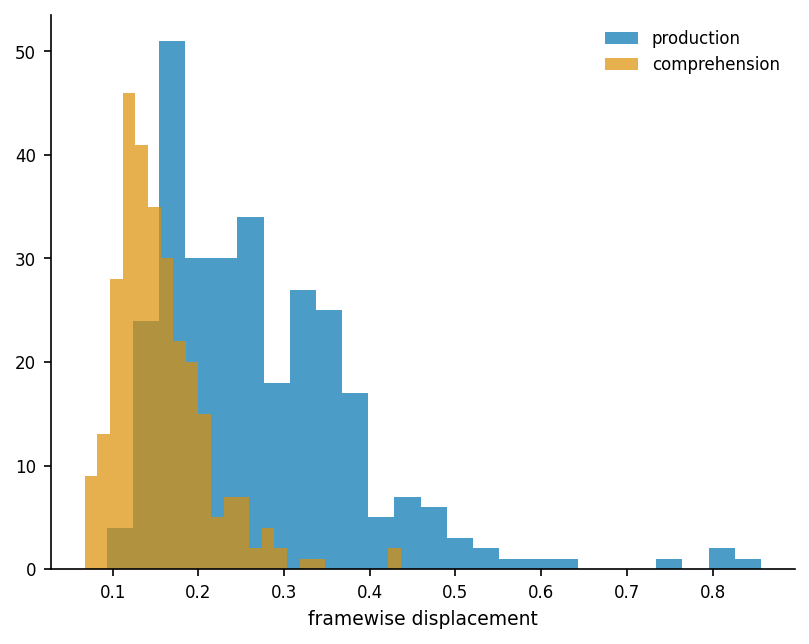

In [116]:
fig, ax = plt.subplots()
ax.hist(prod_fds, bins=25, alpha=0.7, color=BLU, label='production')
ax.hist(comp_fds, bins=25, alpha=0.7, color=ORG, label='comprehension')
ax.legend()
ax.set_xlabel('framewise displacement')
fig.show()